# Streaming and interruption

## Review

In module 2, we built a deeper understanding of both state and memory.

We worked up to a Chatbot with external memory that uses a few tricks (e.g., message history summarization). 

## Goals

In this module, we're going to explore another major area of focus for LangGraph, which is `human-in-the-loop`.

As mentioned, this is a simple Human-in-the-loop (HIL) interaction! 

These interactions are crucial for many agentic systems, and one of the most common use-cases is tool-use-approval.

For example, many tools (e.g., database actions, writing to external systems) may be sensitive and require human approval before execution.

We'll built up to an agent that uses human-in-the-loop for tool approval. 

But, first, we'll introduce the simplest form of human-in-the-loop -- just interrupting the graph -- along with streaming.

--- 

TO ADD: 
 
* token by token streaming (astream events)
* cover messages mode (from API)

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

## Streaming

LangGraph is built with first class support for streaming!

Let's set up our from Module 2, and show how this can be used with streaming.

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")

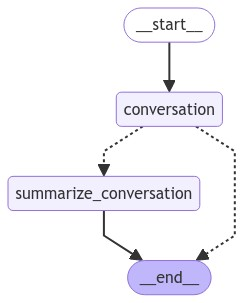

In [2]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

# State 
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Streaming full state

Now, let's [stream events](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming) from our graph.
 
LangGraph supports a few [different streaming modes](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) for [graph state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/):
 
* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

Let's examine `stream_mode="updates"`.

Note that all compiled graphs as LangChain runnables, which means that we can use `.stream` or `.astream` [methods](https://python.langchain.com/v0.1/docs/expression_language/streaming/#using-stream).

Because we stream with `updates`, we only see updates to the state after each step of the graph.
 
Here, we can see that updates only include the `AIMessage` update made to `messages` state by the `conversation` node.

In [13]:
# Create a thread
config = {"configurable": {"thread_id": "5"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hello Lance! It's nice to meet you. I'm an AI assistant. How can I help you today? Is there anything specific you'd like to chat about or any questions you have?


In [10]:
# Create a new thread
config = {"configurable": {"thread_id": "6"}}

# Start a conversation
async for chunk in graph.astream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hello Lance! It's nice to meet you. I'm an AI assistant here to help with any questions you might have or tasks you need assistance with. Please feel free to ask me about any topics you're interested in or let me know if there's anything specific I can help you with today. I'll do my best to provide helpful information while being mindful of copyright restrictions.


Now, we can see `stream_mode="values"`.

This is the `full state` of the graph after the `conversation` node is called.

In [14]:
# Start conversation, again
config = {"configurable": {"thread_id": "7"}}
input_message = HumanMessage(content="hi! I'm Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello Lance! It's nice to meet you. I'm an AI assistant. How can I help you today? Is there anything specific you'd like to chat about or any questions you have?


### Streaming tokens

Sometimes we want to stream the tokens from the LLM!

We can do this [using the `.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node).

When we use this, we get `chunk` objects streamed, which are just dicts.

The `event` indicates the type, and we can specifically isolate chunks from our LLM with `on_chat_model_stream`.

The `chunk["data"]` is just an `AIMessage`, which we can stream!

In [33]:
config = {"configurable": {"thread_id": "14"}}
async for chunk in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    kind = chunk["event"]
    if kind == "on_chat_model_stream":
        data = chunk["data"]
        if data["chunk"].content:
            print(data["chunk"].content, end="|")

Hello| Lance!| It's nice| to meet you. How| are you doing today?| Is| there anything I can help| you with or| woul|d you like| to chat about something in| particular?|

### Streaming via the SDK

As shown in Module 2, our chatbot is deployed locally to Studio.

And as shown in Module 1, we can interact with our Chatbot via the SDK for either local (Studio) or Cloud deployment!

Let's get the URL for the local deployment from Studio.

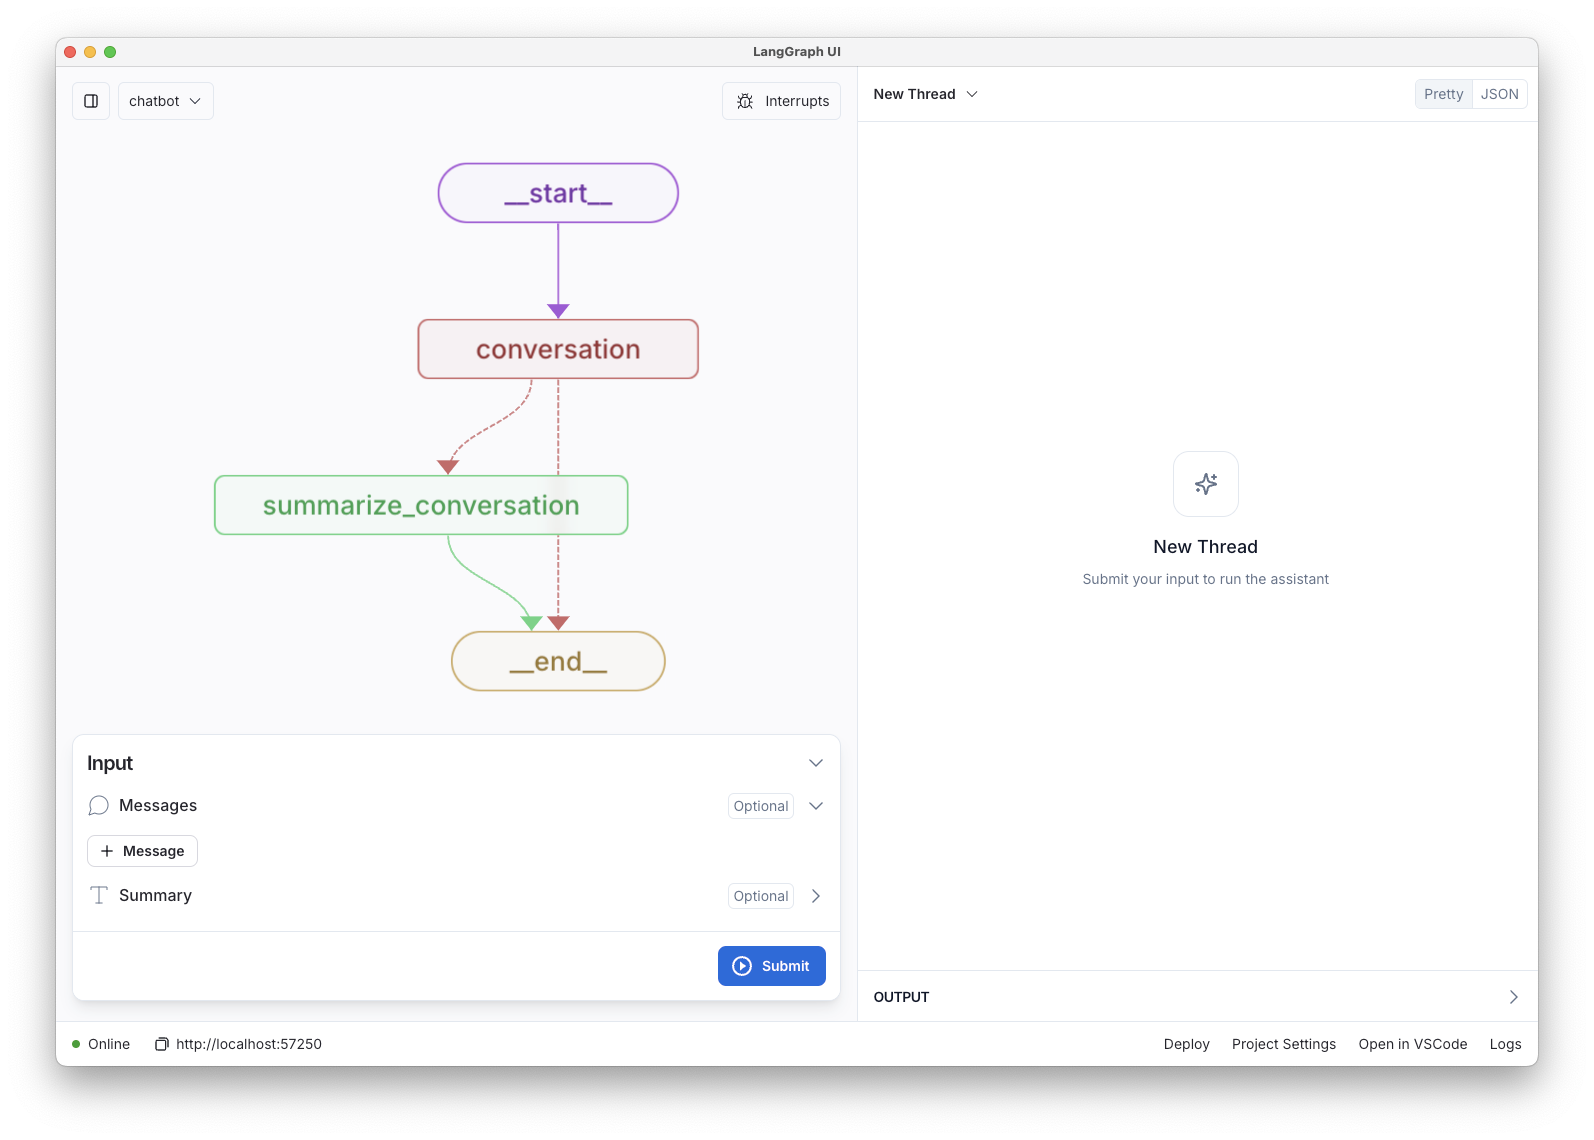

The LangGraph API [supports various streaming modes](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_messages/). 

In [53]:
from langgraph_sdk import get_client

# Replace this with the URL of your own deployed graph
URL = "http://localhost:57250"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()
assistants

[{'assistant_id': '453d1cbf-0bdd-5d35-a224-394f372c0502',
  'graph_id': 'assistant',
  'created_at': '2024-08-26T02:31:20.171308+00:00',
  'updated_at': '2024-08-26T02:31:20.171308+00:00',
  'config': {},
  'metadata': {'created_by': 'system'}},
 {'assistant_id': '8a4ac7a4-50eb-5206-98cc-4a72345cb1f7',
  'graph_id': 'chatbot',
  'created_at': '2024-08-23T19:11:27.632720+00:00',
  'updated_at': '2024-08-23T19:11:27.632720+00:00',
  'config': {},
  'metadata': {'created_by': 'system'}},
 {'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'graph_id': 'agent',
  'created_at': '2024-08-21T20:12:16.736999+00:00',
  'updated_at': '2024-08-21T20:12:16.736999+00:00',
  'config': {},
  'metadata': {'created_by': 'system'}},
 {'assistant_id': '228f9934-0cdd-5383-92c8-ee8422522cc2',
  'graph_id': 'router',
  'created_at': '2024-08-21T18:49:27.365802+00:00',
  'updated_at': '2024-08-21T18:49:27.365802+00:00',
  'config': {},
  'metadata': {'created_by': 'system'}},
 {'assistant_id': '28d99c

Now, we can test streaming, using `messages` mode:

* It outputs messages produced by any chat model called inside (unless tagged in a special way)
* It outputs messages returned from nodes (to allow for nodes to return ToolMessages)

In [57]:
thread = await client.threads.create()

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="chatbot",
    input={"messages": [input_message]},
    stream_mode="messages",):
    
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    elif event.event == "messages/partial":
        for data_item in event.data:
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")
        print("-" * 50)

Metadata: Run ID - 1ef63625-f7c5-6c0e-985f-d478b2dd5140
--------------------------------------------------
--------------------------------------------------
AI: Hi
--------------------------------------------------
AI: Hi Lance
--------------------------------------------------
AI: Hi Lance!
--------------------------------------------------
AI: Hi Lance! How
--------------------------------------------------
AI: Hi Lance! How can
--------------------------------------------------
AI: Hi Lance! How can I
--------------------------------------------------
AI: Hi Lance! How can I assist
--------------------------------------------------
AI: Hi Lance! How can I assist you
--------------------------------------------------
AI: Hi Lance! How can I assist you today
--------------------------------------------------
AI: Hi Lance! How can I assist you today?
--------------------------------------------------
AI: Hi Lance! How can I assist you today?
Response Metadata: Finish Reason - stop
---

## Human-In-The-Loop

Now, as discussed previously we can continue from the last saved checkoint in state by specifying our `thread_id`.

In [4]:
# Continue
input_message = HumanMessage(content="Tell me about the 49ers head coach")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Tell me about the 49ers head coach
================================== Ai Message ==================================

The current head coach of the San Francisco 49ers is Kyle Shanahan. Here are some key points about him:

1. Kyle Shanahan was born on December 14, 1979, in Minneapolis, Minnesota.

2. He was hired as the head coach of the San Francisco 49ers in February 2017.

3. Shanahan is the son of Mike Shanahan, a former NFL head coach who won two Super Bowls with the Denver Broncos.

4. Before becoming the 49ers' head coach, Kyle Shanahan served as an offensive coordinator for several NFL teams, including the Atlanta Falcons, Cleveland Browns, Washington Redskins, and Houston Texans.

5. He is known for his innovative offensive schemes and play-calling abilities.

6. Under Shanahan's leadership, the 49ers reached Super Bowl LIV in 2020, where they lost to the Kansas City Chiefs.

7. He has led the tea

Now, let's use the crudest form of human-in-the-loop.

Let's manually interrupt the graph.

In [5]:
# Continue, but manually break
input_message = HumanMessage(content="Who were his father's top players?")

try:
    for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
        event['messages'][-1].pretty_print()

except KeyboardInterrupt as e:
    print(f"KeyboardInterrupt occurred: {e}")

================================ Human Message =================================

Who were his father's top players?
KeyboardInterrupt occurred: 


We can see that this is interrupted by checking the values in our state.

In [6]:
graph_state = graph.get_state(config)
for m in graph_state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello Lance! It's nice to meet you. How are you doing today? Is there anything I can help you with or would you like to chat about something in particular?
================================ Human Message =================================

Tell me about the 49ers head coach
================================== Ai Message ==================================

The current head coach of the San Francisco 49ers is Kyle Shanahan. Here are some key points about him:

1. Kyle Shanahan was born on December 14, 1979, in Minneapolis, Minnesota.

2. He was hired as the head coach of the San Francisco 49ers in February 2017.

3. Shanahan is the son of Mike Shanahan, a former NFL head coach who won two Super Bowls with the Denver Broncos.

4. Before becoming the 49ers' head coach, Kyle Shanahan served as an offensive coordinator 

The chat model never responded to our question! 

Now, we'll introduce a nice trick.

When we invoke the graph with `None`, it will continue from the last state.

We can view the answer to our question!

In [7]:
for event in graph.stream(None, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================

Mike Shanahan, Kyle's father, coached several notable players during his career, particularly during his successful tenure with the Denver Broncos. Some of his top players include:

1. John Elway - Hall of Fame quarterback who won two Super Bowls under Mike Shanahan's coaching.

2. Terrell Davis - Hall of Fame running back who was crucial to the Broncos' Super Bowl victories.

3. Rod Smith - Pro Bowl wide receiver who played his entire career with the Broncos.

4. Shannon Sharpe - Hall of Fame tight end who was a key part of the Broncos' offense.

5. Steve Young - Hall of Fame quarterback whom Shanahan coached as offensive coordinator for the San Francisco 49ers.

6. Clinton Portis - Pro Bowl running back who played under Shanahan in Denver and later in Washington.

7. Champ Bailey - Hall of Fame cornerback who played for Shanahan in Denver.

8. Al Wilson - Pro Bowl linebacker who anchored the Broncos' de